In [22]:
import h5py
import numpy as np
import pandas as pd
import preprocess_utils
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import random

# Seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

# Parameters for plotting
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Path to the dataset
path = '../dset/data/catalogs'

# Dataset Preprocessing

This notebook prepares the dataset for training the model on foreshocks and aftershocks analysis. The dataset consists of waveforms, each 25 seconds long, with the P-wave arrival fixed at 5 seconds. The metadata also includes information on the S-wave arrival, allowing for potential experiments with spectrograms aligned to the S-wave arrival.

## Purpose
The preprocessing pipeline consists of the following main steps:
1. **Spectrogram Generation**:  
   - Two different spectrogram settings are used to investigate whether SHAP interpretability results depend on these settings. (The specific settings are detailed in the code)  
   - This step ensures that the model's feature importance remains robust across different spectrogram parameters.
   
2. **Feature Extraction**:  
   - Waveforms are processed to extract meaningful features, which will be used as input for the model.  
   - These features are derived from frequency, amplitude, and other relevant characteristics.

By processing the data in this structured way, we ensure a high-quality dataset for training the model and analyzing feature importance with SHAP.


## Data Visualization

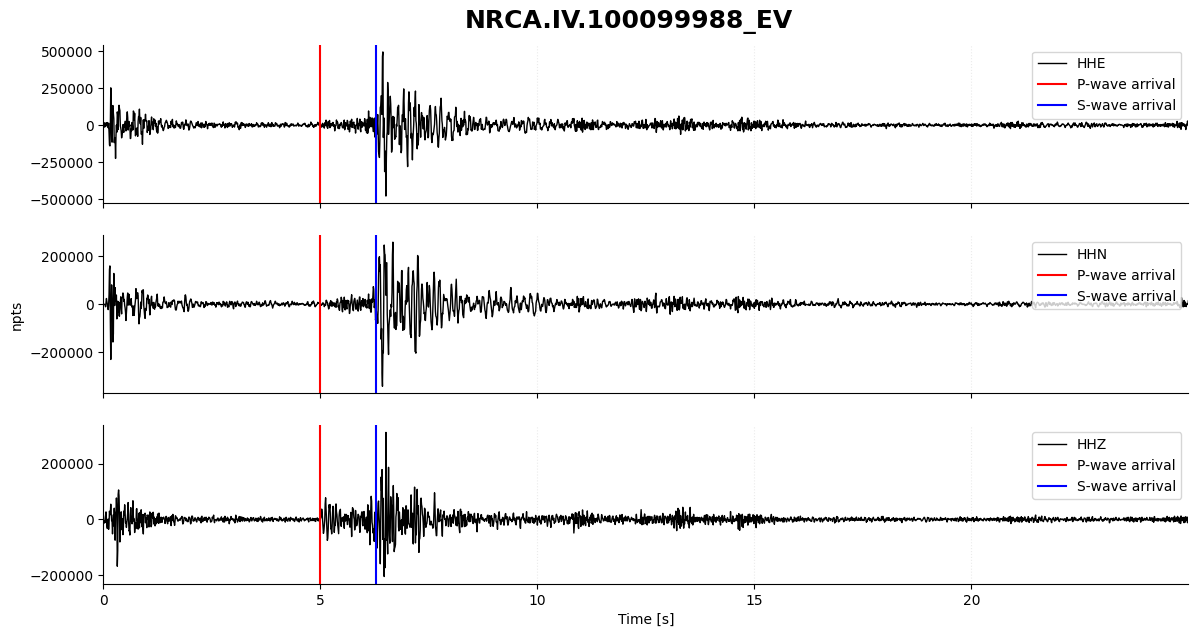

In [31]:
# Example waveform plot

hdf = h5py.File(f'{path}/NRCA/NRCA_post.hdf5', 'r')
df = pd.read_csv(f'{path}/NRCA/NRCA_post_attributes.csv',
                 parse_dates=['trace_start_time'])

idx = 0 # Index of the first event

time = np.arange(0, len(hdf[f'{df.trace_name[idx]}'][:][0]))/100

try:
    fig, ax = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

    plt.suptitle(f'{df.trace_name[idx]}', y=0.93, fontsize=18, fontweight='bold')
    
    ax[0].plot(time, hdf[f'{df.trace_name[idx]}'][:][0], c='k', lw=1, label='HHE')
    ax[0].axvline(5, color='red', label = 'P-wave arrival')
    ax[0].axvline(5 + df.iloc[idx].p_s_diff_sec, color='blue', label = 'S-wave arrival')
    ax[0].set_xlim(time[0], round(time[-1]))
    ax[0].grid(True, alpha=0.25, axis='x', linestyle=':')   
    ax[0].legend(loc = 'upper right')

    ax[1].plot(time, hdf[f'{df.trace_name[idx]}'][:][1], c='k', lw=1, label='HHN')
    ax[1].axvline(5, color='red', label = 'P-wave arrival')
    ax[1].axvline(5 + df.iloc[idx].p_s_diff_sec, color='blue', label = 'S-wave arrival')
    ax[1].set_ylabel('npts')
    ax[1].grid(True, alpha=0.25, axis='x', linestyle=':')
    ax[1].legend(loc = 'upper right')

    ax[2].plot(time, hdf[f'{df.trace_name[idx]}'][:][2], c='k', lw=1, label='HHZ')
    ax[2].axvline(5, c='red', label = 'P-wave arrival')
    ax[2].axvline(5 + df.iloc[idx].p_s_diff_sec, color='blue', label = 'S-wave arrival')
    ax[2].set_xlabel('Time [s]')
    ax[2].grid(True, alpha=0.25, axis='x', linestyle=':')
    ax[2].set_xticks(np.arange(0, 25, 5))
    ax[2].legend(loc = 'upper right')

    plt.show()

except Exception as e:
    print(f'Unable to plot {df.trace_name[idx]}')
    plt.close()

hdf.close()

(3, 1300)


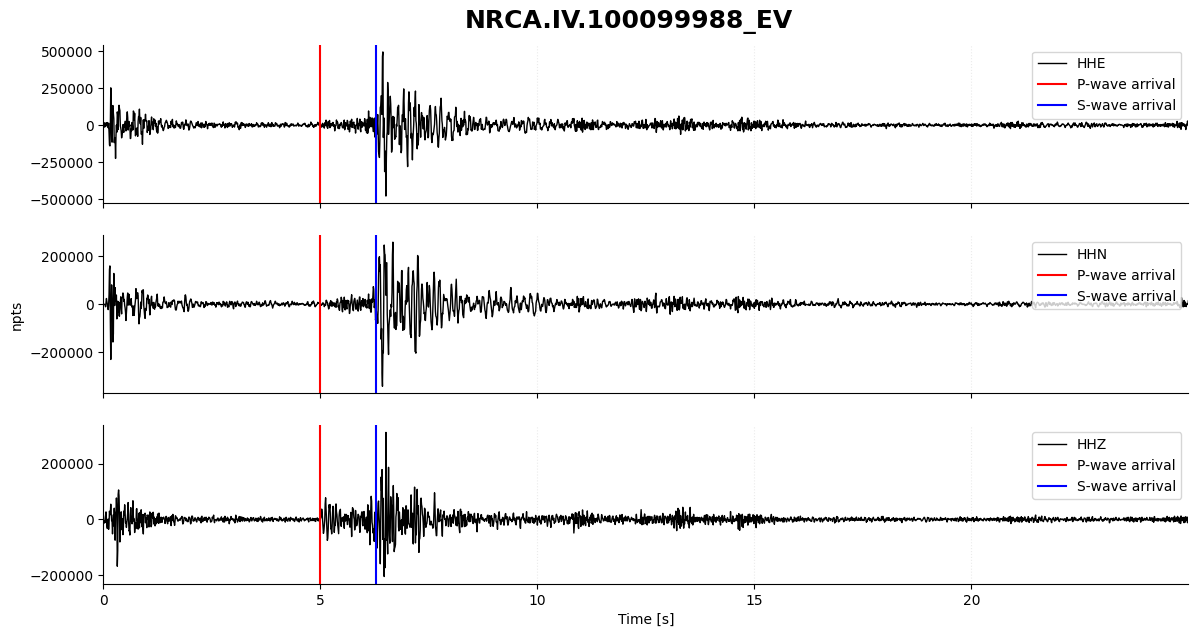

In [37]:
# Example waveform plot

hdf = h5py.File(f'{path}/NRCA/NRCA_post.hdf5', 'r')
df = pd.read_csv(f'{path}/NRCA/NRCA_post_attributes.csv',
                 parse_dates=['trace_start_time'])

idx = 0 # Index of the first event

time = np.arange(0, len(hdf[f'{df.trace_name[idx]}'][:][0]))/100

try:
    fig, ax = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

    plt.suptitle(f'{df.trace_name[idx]}', y=0.93, fontsize=18, fontweight='bold')

    waveform = hdf[f'{df.trace_name[idx]}'][:]
    print((waveform[:,:1300]).shape)
    
    ax[0].plot(time, hdf[f'{df.trace_name[idx]}'][:][0], c='k', lw=1, label='HHE')
    ax[0].axvline(5, color='red', label = 'P-wave arrival')
    ax[0].axvline(5 + df.iloc[idx].p_s_diff_sec, color='blue', label = 'S-wave arrival')
    ax[0].set_xlim(time[0], round(time[-1]))
    ax[0].grid(True, alpha=0.25, axis='x', linestyle=':')   
    ax[0].legend(loc = 'upper right')

    ax[1].plot(time, hdf[f'{df.trace_name[idx]}'][:][1], c='k', lw=1, label='HHN')
    ax[1].axvline(5, color='red', label = 'P-wave arrival')
    ax[1].axvline(5 + df.iloc[idx].p_s_diff_sec, color='blue', label = 'S-wave arrival')
    ax[1].set_ylabel('npts')
    ax[1].grid(True, alpha=0.25, axis='x', linestyle=':')
    ax[1].legend(loc = 'upper right')

    ax[2].plot(time, hdf[f'{df.trace_name[idx]}'][:][2], c='k', lw=1, label='HHZ')
    ax[2].axvline(5, c='red', label = 'P-wave arrival')
    ax[2].axvline(5 + df.iloc[idx].p_s_diff_sec, color='blue', label = 'S-wave arrival')
    ax[2].set_xlabel('Time [s]')
    ax[2].grid(True, alpha=0.25, axis='x', linestyle=':')
    ax[2].set_xticks(np.arange(0, 25, 5))
    ax[2].legend(loc = 'upper right')

    plt.show()

except Exception as e:
    print(f'Unable to plot {df.trace_name[idx]}')
    plt.close()

Frequency range: 0.0 - 50.0 Hz
Time range: 0.32 - 24.63 s
Sxx.shape = (3, 33, 188)


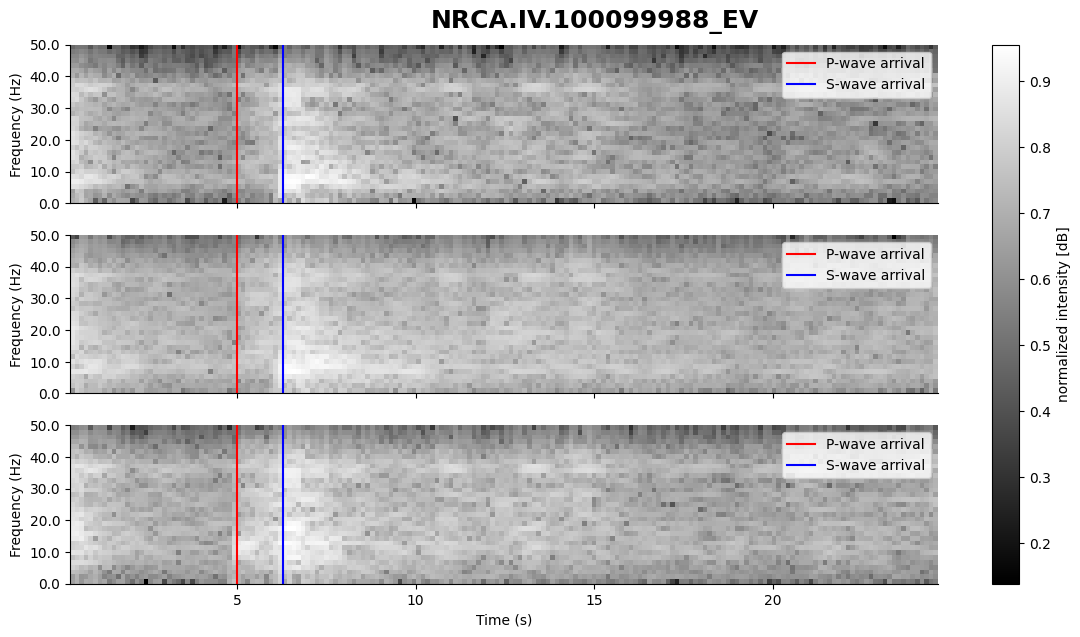

In [3]:
# Example spectrogram plot with first spectrogram settings (NPERSEG = 64, NOVERLAP = NPERSEG * 0.8)

hdf = h5py.File(f'{path}/NRCA/NRCA_post.hdf5', 'r')
df = pd.read_csv(f'{path}/NRCA/NRCA_post_attributes.csv',
                 parse_dates=['trace_start_time'])

idx = 0 # Index of the first event

try:
    fig, axes = plt.subplots(3, 1, figsize=(14, 7), sharex=True)

    plt.suptitle(f'{df.trace_name[idx]}', y=0.93, fontsize=18, fontweight='bold')

    f, t, Sxx = preprocess_utils.compute_db_spectrograms(hdf[f'{df.trace_name[idx]}'])
    components = ['HHE', 'HHN', 'HHZ']

    for i in range(3):
        im = axes[i].imshow(Sxx[i], aspect='auto', cmap='gray', origin='lower', extent=[t[0], t[-1], f[0], f[-1]])
        axes[i].set_ylabel("Frequency (Hz)")
        axes[i].axvline(5, c='red', label = 'P-wave arrival')
        axes[i].axvline(5 + df.iloc[idx].p_s_diff_sec, color='blue', label = 'S-wave arrival')
        axes[i].legend(loc = 'upper right')
        #axes[i].set_title(f"Spectrogram for Component {components[i]}")
        axes[i].set_yticks(np.linspace(f[0], f[-1], num=6))  # Adjust number of ticks as needed
        axes[i].set_yticklabels([f"{freq:.1f}" for freq in np.linspace(f[0], f[-1], num=6)])  # Format frequency labels
    axes[-1].set_xlabel("Time (s)")

    plt.colorbar(im, ax=axes, orientation='vertical', label='normalized intensity [dB]')

    print(f"Frequency range: {f[0].item()} - {f[-1].item()} Hz")
    print(f"Time range: {t[0].item()} - {t[-1].item()} s")
    print(f"{Sxx.shape = }")

except Exception as e:
    print(f'Unable to plot {df.trace_name[idx]}: {e}')
    plt.close()

hdf.close()

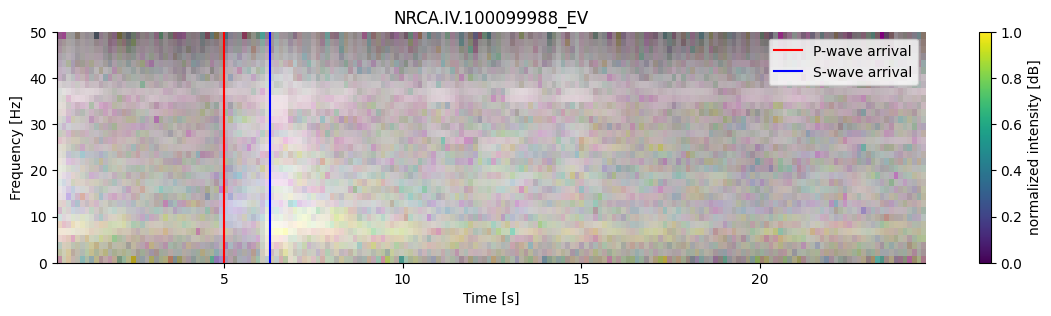

In [4]:
rgb_log_spectrogram = Sxx.transpose((1, 2, 0))

# Example RGB spectrogram plot with first spectrogram settings (NPERSEG = 64, NOVERLAP = NPERSEG * 0.8)
plt.figure(figsize=(14, 3))
plt.imshow(rgb_log_spectrogram, aspect='auto', origin='lower', extent=[t[0], t[-1], f[0], f[-1]])
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title(f'{df.trace_name[idx]}')
plt.colorbar(label='normalized intensity [dB]')
plt.axvline(5, c='red', label = 'P-wave arrival')
plt.axvline((5 + df.iloc[idx].p_s_diff_sec), color='blue', label = 'S-wave arrival')
plt.legend(loc = 'upper right')
plt.show()


## Batch Preprocessing for Spectrograms

In [74]:
import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import preprocess_utils

# Filepaths Definition
basepath = os.path.join(path, 'NRCA')
filepath_post, filepath_pre = os.path.join(basepath, 'NRCA_post.hdf5'), os.path.join(basepath, 'NRCA_pre.hdf5')
meta_df_post, meta_df_pre = pd.read_csv(os.path.join(basepath, 'NRCA_post_attributes.csv')), pd.read_csv(os.path.join(basepath, 'NRCA_pre_attributes.csv'))
colocated_df = pd.read_pickle("../dset/dataframe_NRCA_SelectedSimilarTraces.csv")

# Output folders structure
output = '../preprocessed_dset'
spectrograms_output = os.path.join(output, 'spectrograms')
os.makedirs(output, exist_ok=True)
os.makedirs(spectrograms_output, exist_ok=True)

# Shuffle dataset and split into 80% train, 20% test
all_traces = list(meta_df_post.trace_name) + list(meta_df_pre.trace_name)
random.shuffle(all_traces)

split_idx = int(len(all_traces) * 0.8)
train_traces = set(all_traces[:split_idx])
valid_traces = set(all_traces[split_idx:])

In [75]:
all_pre = []

hdf_pre = h5py.File(filepath_pre, 'r')
for trace in tqdm(meta_df_pre.trace_name, desc = f'Computing RGB Foreshocks Spectrograms'):
    try:
        waveform = hdf_pre[trace][:]
        waveform = waveform[:,:1300]

        f, t, Sxx = preprocess_utils.compute_db_spectrograms(waveform)
        Sxx = Sxx.transpose((1,2,0))
        trace_filename = f'{trace}.png'
        plt.imsave(os.path.join(spectrograms_output, trace_filename), Sxx)

        row = meta_df_pre[meta_df_pre.trace_name == trace].copy()
        row['label'] = 'pre'
        row['split'] = 'train' if trace in train_traces else 'test'
        row['filename'] = trace_filename

        if trace in colocated_df['trace_name'].values:
            associato = colocated_df.loc[colocated_df['trace_name'] == trace, 'associato_ev'].iloc[0]
            row['associato'] = int(associato + 1)
        else:
            row['associato'] = int(0)

        all_pre.append(row)
        
    except Exception as e:
        print(f'Unable to analyze trace {trace}: {e}')

hdf_pre.close()

Computing RGB Foreshocks Spectrograms:  53%|█████▎    | 1911/3636 [00:18<00:15, 114.76it/s]

Unable to analyze trace NRCA.IV.100709001_EV: Third dimension must be 3 or 4


Computing RGB Foreshocks Spectrograms:  86%|████████▋ | 3139/3636 [00:29<00:04, 99.82it/s] 

Unable to analyze trace NRCA.IV.100019941_EV: Third dimension must be 3 or 4
Unable to analyze trace NRCA.IV.100019946_EV: Third dimension must be 3 or 4
Unable to analyze trace NRCA.IV.100019950_EV: Third dimension must be 3 or 4


Computing RGB Foreshocks Spectrograms: 100%|██████████| 3636/3636 [00:34<00:00, 106.63it/s]


In [76]:
all_post = []

hdf_post = h5py.File(filepath_post, 'r')
for trace in tqdm(meta_df_post.trace_name, desc = f'Computing RGB Aftershocks Spectrograms'):
    try:
        waveform = hdf_post[trace]
        waveform = waveform[:,:1300]

        f, t, Sxx = preprocess_utils.compute_db_spectrograms(waveform)
        Sxx = Sxx.transpose((1,2,0))
        trace_filename = f'{trace}.png'
        plt.imsave(os.path.join(spectrograms_output, trace_filename), Sxx)

        row = meta_df_post[meta_df_post.trace_name == trace].copy()
        row['label'] = 'post'
        row['split'] = 'train' if trace in train_traces else 'test'
        row['filename'] = trace_filename

        if trace in colocated_df['trace_name'].values:
            associato = colocated_df.loc[colocated_df['trace_name'] == trace, 'associato_ev'].iloc[0]
            row['associato'] = int(associato + 1)
        else:
            row['associato'] = int(0)

        all_post.append(row)
        
    except Exception as e:
        print(f'Unable to analyze trace {trace}: {e}')

hdf_post.close()

Computing RGB Aftershocks Spectrograms:   0%|          | 0/2194 [00:00<?, ?it/s]

Computing RGB Aftershocks Spectrograms: 100%|██████████| 2194/2194 [00:18<00:00, 121.10it/s]


In [77]:
np.save(os.path.join(spectrograms_output, 'f_t_range.npy'), np.array([f[0].item(), f[-1].item(), t[0].item(), t[-1].item()]))
print(np.array([f[0].item(), f[-1].item(), t[0].item(), t[-1].item()]))
final_df = pd.concat(all_post + all_pre, ignore_index=True)

# Convert the trace_start_time column to datetime (if not already)
final_df['trace_start_time'] = pd.to_datetime(final_df['trace_start_time'])

# Get the ISO week number for each event
final_df['week'] = final_df['trace_start_time'].dt.isocalendar().week

# Count occurrences for nonzero associato values
nonzero_counts = final_df.loc[final_df['associato'] != 0, 'associato'].value_counts()

# Identify associato values that occur only once
singles = nonzero_counts[nonzero_counts == 1].index

# Replace these single-occurrence values with 0
final_df.loc[final_df['associato'].isin(singles), 'associato'] = 0

# Save to CSV
final_df.to_csv(os.path.join(output, 'metadata.csv'), index=False)

[ 0.   50.    0.32 12.67]


In [78]:
final_df

,trace_name,trace_start_time,network_code,receiver_name,receiver_type,receiver_elevation_m,receiver_latitude,receiver_longitude,source_id,source_depth_km,...,source_magnitude,source_origin_time,p_travel_sec,s_travel_sec,p_s_diff_sec,label,split,filename,associato,week
0,NRCA.IV.100099988_EV,2016-10-31 00:15:23.830000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100099988,6.455,...,2.14,2016-10-31 00:15:27.368,1.462,2.752,1.29,post,train,NRCA.IV.100099988_EV.png,0,44
1,NRCA.IV.100100306_EV,2016-10-31 00:52:25.610000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100100306,2.787,...,2.25,2016-10-31 00:52:29.149,1.461,3.281,1.82,post,train,NRCA.IV.100100306_EV.png,0,44
2,NRCA.IV.100100326_EV,2016-10-31 00:54:30.840000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100100326,3.751,...,2.60,2016-10-31 00:54:35.100,0.740,3.220,2.48,post,train,NRCA.IV.100100326_EV.png,0,44
3,NRCA.IV.100100799_EV,2016-10-31 01:48:19.170000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100100799,2.047,...,3.31,2016-10-31 01:48:22.398,1.772,3.442,1.67,post,train,NRCA.IV.100100799_EV.png,0,44
4,NRCA.IV.100100996_EV,2016-10-31 02:11:39.660000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100100996,5.819,...,2.08,2016-10-31 02:11:43.199,1.461,2.861,1.40,post,test,NRCA.IV.100100996_EV.png,0,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,NRCA.IV.100057770_EV,2016-10-26 13:42:07.610000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100057770,2.078,...,0.70,2016-10-26 13:42:11.545,1.065,2.105,1.04,pre,train,NRCA.IV.100057770_EV.png,0,43
5822,NRCA.IV.100057800_EV,2016-10-26 14:01:04.860000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100057800,6.330,...,1.40,2016-10-26 14:01:08.404,1.456,2.736,1.28,pre,train,NRCA.IV.100057800_EV.png,0,43
5823,NRCA.IV.100057809_EV,2016-10-26 14:08:41.830000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100057809,7.556,...,0.58,2016-10-26 14:08:45.331,1.499,2.829,1.33,pre,train,NRCA.IV.100057809_EV.png,0,43
5824,NRCA.IV.100057875_EV,2016-10-26 14:39:43.740000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100057875,4.063,...,0.71,2016-10-26 14:39:47.563,1.177,2.227,1.05,pre,train,NRCA.IV.100057875_EV.png,0,43


In [79]:
final_df[final_df.associato != 0].sort_values(by=['associato']) 

,trace_name,trace_start_time,network_code,receiver_name,receiver_type,receiver_elevation_m,receiver_latitude,receiver_longitude,source_id,source_depth_km,...,source_magnitude,source_origin_time,p_travel_sec,s_travel_sec,p_s_diff_sec,label,split,filename,associato,week
62,NRCA.IV.100111401_EV,2016-10-31 22:55:03.280000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100111401,5.397,...,1.86,2016-10-31 22:55:07.027,1.253,2.423,1.17,post,train,NRCA.IV.100111401_EV.png,1,44
2267,NRCA.IV.100592757_EV,2016-08-24 15:55:01.930000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100592757,5.383,...,1.90,2016-08-24 15:55:05.671,1.259,2.399,1.14,pre,train,NRCA.IV.100592757_EV.png,1,34
2353,NRCA.IV.100597997_EV,2016-08-25 09:53:50.280000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100597997,7.182,...,1.53,2016-08-25 09:53:53.795,1.485,2.815,1.33,pre,train,NRCA.IV.100597997_EV.png,2,34
68,NRCA.IV.100135390_EV,2016-11-01 04:53:42.570000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100135390,7.234,...,1.53,2016-11-01 04:53:46.068,1.502,2.862,1.36,post,train,NRCA.IV.100135390_EV.png,2,44
328,NRCA.IV.100354757_EV,2016-11-06 04:12:45.590000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100354757,5.357,...,1.10,2016-11-06 04:12:49.379,1.211,2.321,1.11,post,train,NRCA.IV.100354757_EV.png,3,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5306,NRCA.IV.100019412_EV,2016-10-14 17:43:47.110000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100019412,4.566,...,0.89,2016-10-14 17:43:50.969,1.141,2.211,1.07,pre,train,NRCA.IV.100019412_EV.png,180,41
937,NRCA.IV.100254657_EV,2016-11-22 00:38:14.220000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100254657,4.016,...,0.92,2016-11-22 00:38:18.198,1.022,1.942,0.92,post,test,NRCA.IV.100254657_EV.png,186,47
5513,NRCA.IV.100032954_EV,2016-10-18 20:42:03.130000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100032954,4.040,...,0.97,2016-10-18 20:42:07.104,1.026,1.976,0.95,pre,test,NRCA.IV.100032954_EV.png,186,42
1598,NRCA.IV.100553530_EV,2016-12-05 11:41:47.450000+00:00,IV,NRCA,HH,927.0,42.83355,13.11427,100553530,3.988,...,0.93,2016-12-05 11:41:51.365,1.085,2.055,0.97,post,train,NRCA.IV.100553530_EV.png,188,49
